# Importing Libraries


In [1]:
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression,OrthogonalMatchingPursuit, OrthogonalMatchingPursuit,  Lasso, Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from tensorflow.keras import layers
from tensorflow import keras
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor


import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

# Loading the data

In [3]:
file_path = "data/Sensor_Data.xlsx"

dfs = []

with pd.ExcelFile(file_path) as xlsx:
    for sheet_name in xlsx.sheet_names:
        df = pd.read_excel(xlsx, sheet_name)
        dfs.append(df)

combined_df = df = pd.concat(dfs, ignore_index=True)
df = combined_df.copy()
df["Irradiance(W/m2)"] = df["Light Intensity(lumens)"]*0.079

mod_df = pd.DataFrame(columns= ["Timestamp", "Temperature(Â°C)", "Irradiance(W/m2)", "Power(Watts)"])
count = 0
while count <= 34433:
    temp = sum(df.iloc[count:count + 360]["Temperature(Â°C)"]) / 360
    irr = sum(df.iloc[count:count + 360]["Irradiance(W/m2)"]) / 360
    power = sum(df.iloc[count:count + 360]["Power(Watts)"]) / 360
    time = df.iloc[count]["Timestamp"]

    count = count + 360

    mod_df = mod_df.append({"Timestamp": time, "Temperature(Â°C)":temp, "Irradiance(W/m2)":irr, "Power(Watts)": power }, ignore_index = True)

        
df  = mod_df.copy()

In [4]:
df

,Timestamp,Temperature(Â°C),Irradiance(W/m2),Power(Watts)
0,23 Feb 2023 10:07:38 Thu,27.604167,232.056794,171.280327
1,23 Feb 2023 11:10:51 Thu,24.138889,222.903328,173.437217
2,23 Feb 2023 12:16:45 Thu,20.525556,221.049242,176.049974
3,23 Feb 2023 13:19:59 Thu,16.706944,203.869375,164.480974
4,23 Feb 2023 14:23:13 Thu,16.968333,207.123517,171.876276
...,...,...,...,...
91,28 Mar 2023 12:05:10 Tue,12.839167,160.987517,110.016519
92,28 Mar 2023 13:08:24 Tue,12.064722,139.914047,89.523731
93,28 Mar 2023 14:11:39 Tue,11.042778,136.808689,65.785551
94,28 Mar 2023 15:14:53 Tue,11.534167,148.544797,92.771345


In [33]:
results = pd.DataFrame(columns=["Model_name", "RMSE"])

# Radial basis Neural Network

In [49]:


X = df[['Temperature(Â°C)', "Irradiance(W/m2)"]].values
y = df["Power(Watts)"].values

scaler_X =  MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

train_size = int(len(df) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

class RBFNet(object):
    def __init__(self, input_dim, hidden_dim, output_dim, sigma=1.0):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.sigma = sigma
        self.centers = None
        self.weights = None
        
    def _gaussian(self, x, center):
        return np.exp(-self.sigma*np.linalg.norm(x-center)**2)
    
    def _design_matrix(self, X):
        dist = cdist(X, self.centers)
        return np.array([self._gaussian(X[i], self.centers[j]) for i in range(len(X)) for j in range(len(self.centers))]).reshape((len(X), len(self.centers)))
    
    def fit(self, X, y):
        from sklearn.cluster import KMeans
        kmeans = KMeans(n_clusters=self.hidden_dim, random_state=0).fit(X)
        self.centers = kmeans.cluster_centers_
        phi = self._design_matrix(X)
        self.weights = np.linalg.lstsq(phi, y, rcond=None)[0]
        
    def predict(self, X):
        phi = self._design_matrix(X)
        y_pred = np.dot(phi, self.weights)
        return y_pred
    
    def summary(self):
        print("RBFNet Model Summary")
        print("--------------------")
        print(f"Input Dimension: {self.input_dim}")
        print(f"Hidden Dimension: {self.hidden_dim}")
        print(f"Output Dimension: {self.output_dim}")
        print(f"Sigma: {self.sigma}")

input_dim = 2
hidden_dim = 3
output_dim = 1
sigma = 1.0

rbfnet = RBFNet(input_dim, hidden_dim, output_dim, sigma)


rbfnet.fit(X_train, y_train)


y_pred = rbfnet.predict(X_test)

mse_1 = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse_1:.10f}')
print(f'\n')
rbfnet.summary()

Mean Squared Error: 0.0130342561


RBFNet Model Summary
--------------------
Input Dimension: 2
Hidden Dimension: 3
Output Dimension: 1
Sigma: 1.0


In [50]:
y_pred = rbfnet.predict(X_test)
y_pred_orig = scaler_y.inverse_transform(y_pred)

y_train_pred = rbfnet.predict(X_train)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred)

rmse_1 = np.sqrt(mean_squared_error(y[train_size:], y_pred_orig))

rmse_train = np.sqrt(mean_squared_error(y[:train_size], y_train_pred_orig))

print(f'Test Root Mean Squared Error: {rmse_1:.10f}')
print(f'Train Root Mean Squared Error: {rmse_train:.10f}')
print(f'\n')
rbfnet.summary()

Test Root Mean Squared Error: 23.6407932966
Train Root Mean Squared Error: 21.9671847274


RBFNet Model Summary
--------------------
Input Dimension: 2
Hidden Dimension: 3
Output Dimension: 1
Sigma: 1.0


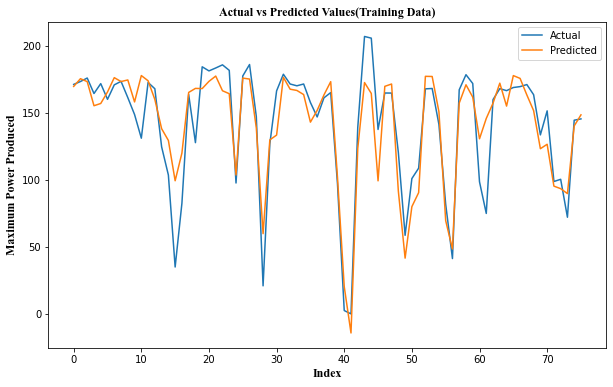

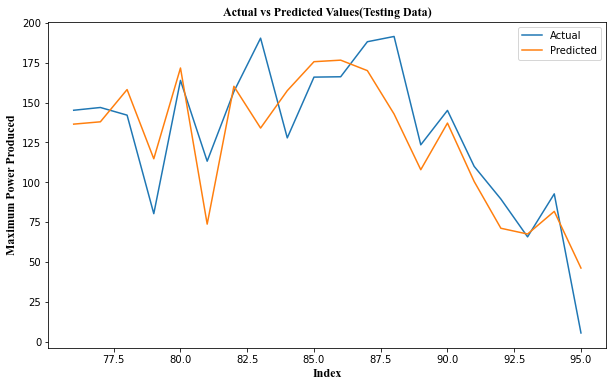

In [36]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[:train_size], y[:train_size], label='Actual')
plt.plot(df.index[:train_size], y_train_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Training Data)", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("Index", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()

plt.show()


plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size:], y[train_size:], label='Actual')
plt.plot(df.index[train_size:], y_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Testing Data)" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("Index", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend(loc = 'upper right')

plt.show()


In [37]:
results = results.append({"Model_name":"Radial Basis Function Neural Network","RMSE": rmse_1}, ignore_index = True)
results

,Model_name,RMSE
0,Radial Basis Function Neural Network,25.202064


# LSTM

In [38]:
train_size = int(len(df) * 0.8)
train_data = df[:int(0.8 * len(df))].copy()
test_data = df[int(0.8 * len(df)):].copy()

scaler = MinMaxScaler()
train_data[['Temperature(Â°C)', "Irradiance(W/m2)", 'Power(Watts)']] = scaler.fit_transform(train_data[['Temperature(Â°C)', "Irradiance(W/m2)", 'Power(Watts)']])
train_data = train_data[['Temperature(Â°C)', "Irradiance(W/m2)", 'Power(Watts)']].copy()
test_data[['Temperature(Â°C)', "Irradiance(W/m2)", 'Power(Watts)']] = scaler.transform(test_data[['Temperature(Â°C)', "Irradiance(W/m2)", 'Power(Watts)']])
test_data = test_data[['Temperature(Â°C)', "Irradiance(W/m2)", 'Power(Watts)']].copy()

time_steps = 5

def create_sequences(dated_data, time_steps):
    X = []
    y = []
    for i in range(len(dated_data) - time_steps):        
        X.append(dated_data.iloc[i:i + time_steps, :2].values)
        y.append(dated_data.iloc[i + time_steps, 2])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_data, time_steps)
X_test, y_test = create_sequences(test_data, time_steps)

X_train = X_train.reshape(-1, time_steps, 2)
X_test = X_test.reshape(-1, time_steps, 2)



model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(loss='mse', optimizer=Adam(lr=0.001))
history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1, validation_data=(X_test, y_test))

Epoch 1/50
3/3 [==============================] - 7s 641ms/step - loss: 0.4769 - val_loss: 0.3273
Epoch 2/50
3/3 [==============================] - 0s 27ms/step - loss: 0.3456 - val_loss: 0.2254
Epoch 3/50
3/3 [==============================] - 0s 27ms/step - loss: 0.2342 - val_loss: 0.1401
Epoch 4/50
3/3 [==============================] - 0s 26ms/step - loss: 0.1507 - val_loss: 0.0748
Epoch 5/50
3/3 [==============================] - 0s 29ms/step - loss: 0.0850 - val_loss: 0.0419
Epoch 6/50
3/3 [==============================] - 0s 29ms/step - loss: 0.0726 - val_loss: 0.0473
Epoch 7/50
3/3 [==============================] - 0s 28ms/step - loss: 0.0806 - val_loss: 0.0563
Epoch 8/50
3/3 [==============================] - 0s 30ms/step - loss: 0.0995 - val_loss: 0.0471
Epoch 9/50
3/3 [==============================] - 0s 30ms/step - loss: 0.0754 - val_loss: 0.0407
Epoch 10/50
3/3 [==============================] - 0s 37ms/step - loss: 0.0684 - val_loss: 0.0434
Epoch 11/50
3/3 [===========

In [11]:
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

y_pred = scaler.inverse_transform(np.hstack((X_test[:, -1, :2], y_pred.reshape(-1, 1))))
y_pred = y_pred[:, -1]

y_test_is = scaler.inverse_transform(np.hstack((X_test[:, -1, :2], y_test.reshape(-1, 1))))
y_test_is = y_test_is[:, -1]

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test_is, y_pred)

print('RMSE on test data (original):', np.sqrt(mse))

y_train_pred = scaler.inverse_transform(np.hstack((X_train[:, -1, :2], y_train_pred.reshape(-1, 1))))
y_train_pred = y_train_pred[:, -1]

y_train_is = scaler.inverse_transform(np.hstack((X_train[:, -1, :2], y_train.reshape(-1, 1))))
y_train_is = y_train_is[:, -1]

mse_t = mean_squared_error(y_train_is, y_train_pred)

print('RMSE on train data (original):', np.sqrt(mse_t))


3/3 [==============================] - 0s 5ms/step
RMSE on test data (original): 40.976100725056085
RMSE on train data (original): 51.41874616588285


In [ ]:
4 - 43

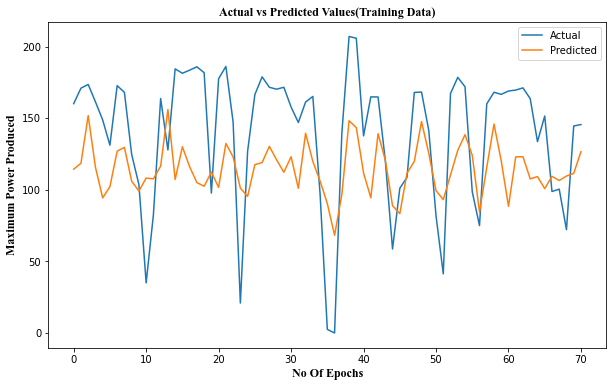

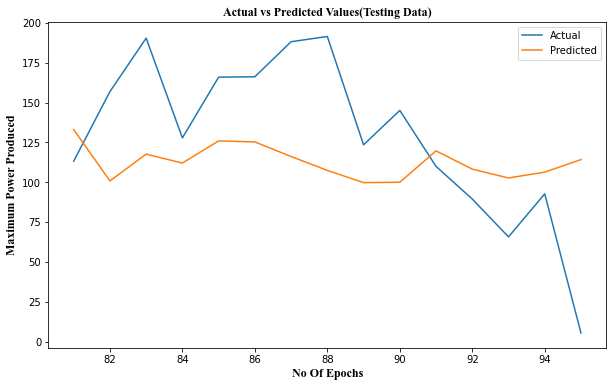

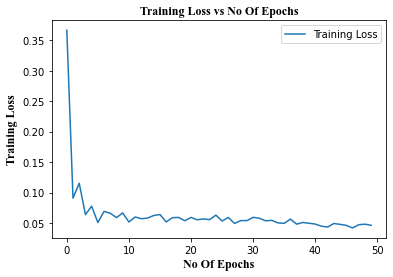

In [40]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[:train_size-time_steps], y_train_is, label='Actual')
plt.plot(df.index[:train_size-time_steps], y_train_pred, label='Predicted')
plt.title("Actual vs Predicted Values(Training Data)", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()

plt.show()


plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size+time_steps:], y_test_is, label='Actual')
plt.plot(df.index[train_size+time_steps:], y_pred, label='Predicted')
plt.title("Actual vs Predicted Values(Testing Data)" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend(loc = 'upper right')

plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.title("Training Loss vs No Of Epochs" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Training Loss", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()
plt.show(model)

In [41]:
results = results.append({"Model_name":"LSTM Neural Network","RMSE": np.sqrt(mse)}, ignore_index = True)
results

,Model_name,RMSE
0,Radial Basis Function Neural Network,25.202064
1,LSTM Neural Network,52.293499


# Modular Neural Network

In [42]:


X = df.copy()[['Temperature(Â°C)', "Irradiance(W/m2)"]].values
y = df.copy()['Power(Watts)'].values

scaler_X =  MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

train_size = int(len(df) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

input_shape = (2,)

inputs = layers.Input(shape=input_shape, name="inputs")

x = layers.Dense(12, activation="relu", name="dense1")(inputs)
x = layers.Dense(32, activation="relu", name="dense2")(x)
x = layers.Dense(64, activation="relu", name="dense3")(x)


outputs = layers.Dense(1, activation="linear", name="outputs")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="modular_nn")

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01), loss="mse"
)

history = model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1, validation_data=(X_test, y_test))






Epoch 1/50
5/5 [==============================] - 1s 40ms/step - loss: 0.1443 - val_loss: 0.0362
Epoch 2/50
5/5 [==============================] - 0s 11ms/step - loss: 0.0359 - val_loss: 0.0556
Epoch 3/50
5/5 [==============================] - 0s 13ms/step - loss: 0.0378 - val_loss: 0.0166
Epoch 4/50
5/5 [==============================] - 0s 14ms/step - loss: 0.0240 - val_loss: 0.0217
Epoch 5/50
5/5 [==============================] - 0s 13ms/step - loss: 0.0206 - val_loss: 0.0231
Epoch 6/50
5/5 [==============================] - 0s 13ms/step - loss: 0.0192 - val_loss: 0.0151
Epoch 7/50
5/5 [==============================] - 0s 13ms/step - loss: 0.0171 - val_loss: 0.0146
Epoch 8/50
5/5 [==============================] - 0s 13ms/step - loss: 0.0147 - val_loss: 0.0197
Epoch 9/50
5/5 [==============================] - 0s 14ms/step - loss: 0.0158 - val_loss: 0.0129
Epoch 10/50
5/5 [==============================] - 0s 14ms/step - loss: 0.0148 - val_loss: 0.0166
Epoch 11/50
5/5 [============

In [43]:
y_pred = model.predict(X_test)
y_pred_orig = scaler_y.inverse_transform(y_pred)

y_train_pred = model.predict(X_train)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred)

rmse_1 = np.sqrt(mean_squared_error(y[train_size:], y_pred_orig))

rmse_train = np.sqrt(mean_squared_error(y[:train_size], y_train_pred_orig))

print(f'Test Root Mean Squared Error: {rmse_1:.10f}')
print(f'Train Root Mean Squared Error: {rmse_train:.10f}')
print(f'\n')
model.summary()

3/3 [==============================] - 0s 4ms/step
Test Root Mean Squared Error: 23.4810340330
Train Root Mean Squared Error: 20.2359349965


Model: "modular_nn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 2)]               0         
                                                                 
 dense1 (Dense)              (None, 12)                36        
                                                                 
 dense2 (Dense)              (None, 32)                416       
                                                                 
 dense3 (Dense)              (None, 64)                2112      
                                                                 
 outputs (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,629
Trainable params: 2,629
No

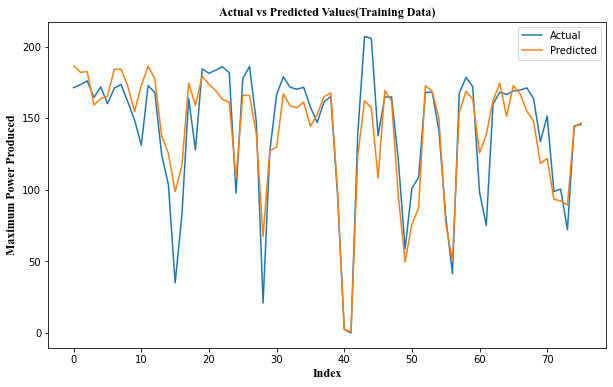

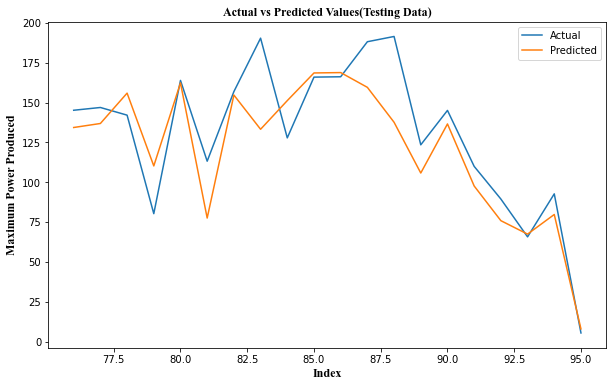

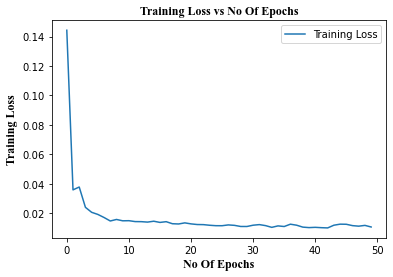

In [44]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[:train_size], y[:train_size], label='Actual')
plt.plot(df.index[:train_size], y_train_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Training Data)", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("Index", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()

plt.show()


plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size:], y[train_size:], label='Actual')
plt.plot(df.index[train_size:], y_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Testing Data)" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("Index", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend(loc = 'upper right')

plt.show()


plt.plot(history.history['loss'], label='Training Loss')
plt.title("Training Loss vs No Of Epochs" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Training Loss", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()
plt.show(model)

In [45]:
results = results.append({"Model_name":"Modular Neural Network","RMSE": rmse_1}, ignore_index = True)
results

,Model_name,RMSE
0,Radial Basis Function Neural Network,25.202064
1,LSTM Neural Network,52.293499
2,Modular Neural Network,23.481034


# Linear Regression (G and T) 

In [46]:

X = df[[ 'Irradiance(W/m2)', 'Temperature(Â°C)']].values
y = df["Power(Watts)"].values

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

train_size = int(len(df) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]



reg_model = LinearRegression()

reg_model.fit(X_train, y_train)

y_pred = reg_model.predict(X_test)
mse_4 = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse_4:.10f}')
b0 = reg_model.intercept_[0]
b = reg_model.coef_

print("Regression equation: Y = P = {:.2f}T + {:.2f}IR - {:.2f}".format(b[0][0], b[0][1], abs(b0)))

Mean Squared Error: 0.0154249892
Regression equation: Y = P = 0.92T + 0.06IR - 0.00


In [47]:
y_pred = reg_model.predict(X_test)
y_pred_orig = scaler_y.inverse_transform(y_pred)

y_train_pred = reg_model.predict(X_train)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred)

rmse_1 = np.sqrt(mean_squared_error(y[train_size:], y_pred_orig))

rmse_train = np.sqrt(mean_squared_error(y[:train_size], y_train_pred_orig))

print(f'Test Root Mean Squared Error: {rmse_1:.10f}')
print(f'Train Root Mean Squared Error: {rmse_train:.10f}')

Test Root Mean Squared Error: 25.7176543531
Train Root Mean Squared Error: 24.7411490739


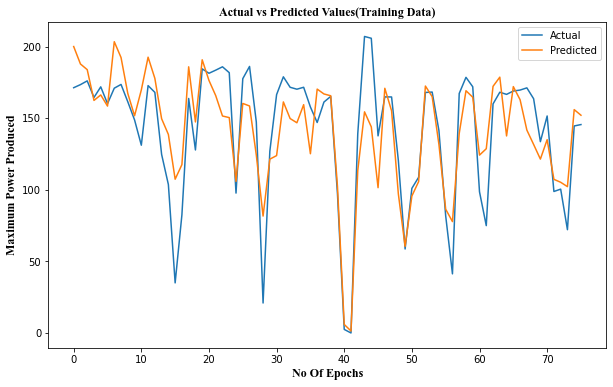

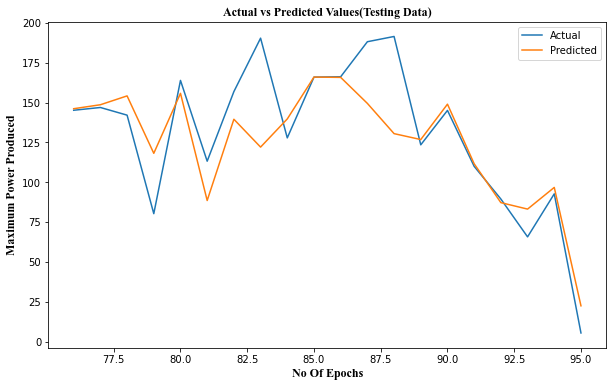

In [48]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[:train_size], y[:train_size], label='Actual')
plt.plot(df.index[:train_size], y_train_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Training Data)", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()

plt.show()


plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size:], y[train_size:], label='Actual')
plt.plot(df.index[train_size:], y_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Testing Data)" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend(loc = 'upper right')

plt.show()

In [49]:
results = results.append({"Model_name":"Linear Regression(G and T)","RMSE": rmse_1}, ignore_index = True)
results

,Model_name,RMSE
0,Radial Basis Function Neural Network,25.202064
1,LSTM Neural Network,52.293499
2,Modular Neural Network,23.481034
3,Linear Regression(G and T),25.717654


# Support Vector Machines

In [50]:
X = df[['Irradiance(W/m2)', 'Irradiance(W/m2)']].values
y = df["Power(Watts)"].values

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

train_size = int(len(df) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]



model = SVR(kernel='rbf')

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse_5 = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse_5:.10f}')

Mean Squared Error: 0.0176482470


In [51]:
y_pred = model.predict(X_test)
y_pred_orig = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

y_train_pred = model.predict(X_train)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred.reshape(-1, 1))

rmse_1 = np.sqrt(mean_squared_error(y[train_size:], y_pred_orig))

rmse_train = np.sqrt(mean_squared_error(y[:train_size], y_train_pred_orig))

print(f'Test Root Mean Squared Error: {rmse_1:.10f}')
print(f'Train Root Mean Squared Error: {rmse_train:.10f}')

Test Root Mean Squared Error: 27.5086772557
Train Root Mean Squared Error: 22.6475423530


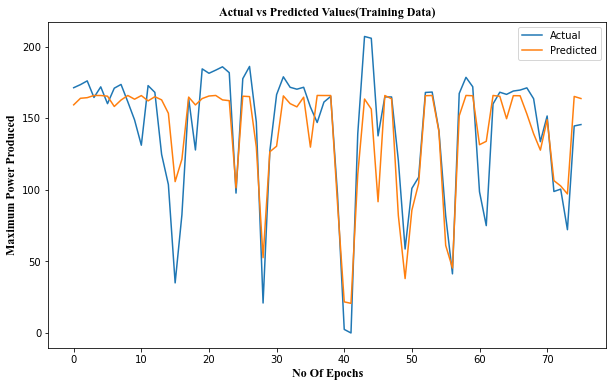

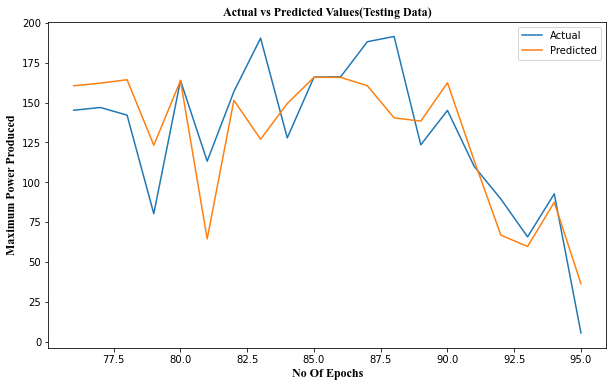

In [52]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[:train_size], y[:train_size], label='Actual')
plt.plot(df.index[:train_size], y_train_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Training Data)", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()

plt.show()


plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size:], y[train_size:], label='Actual')
plt.plot(df.index[train_size:], y_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Testing Data)" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend(loc = 'upper right')

plt.show()

In [53]:
results = results.append({"Model_name":"Support Vector Machines","RMSE": rmse_1}, ignore_index = True)
results

,Model_name,RMSE
0,Radial Basis Function Neural Network,25.202064
1,LSTM Neural Network,52.293499
2,Modular Neural Network,23.481034
3,Linear Regression(G and T),25.717654
4,Support Vector Machines,27.508677


# Decision Tree Regressor

In [54]:
X = df[['Temperature(Â°C)', 'Irradiance(W/m2)']].values
y = df["Power(Watts)"].values

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

train_size = int(len(df) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

model = DecisionTreeRegressor( max_depth= 50, min_samples_leaf=10)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

y_pred = model.predict(X_test)
y_pred_orig = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

y_train_pred = model.predict(X_train)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred.reshape(-1, 1))

rmse_1 = np.sqrt(mean_squared_error(y[train_size:], y_pred_orig))

rmse_train = np.sqrt(mean_squared_error(y[:train_size], y_train_pred_orig))

print(f'Test Root Mean Squared Error: {rmse_1:.10f}')
print(f'Train Root Mean Squared Error: {rmse_train:.10f}')

Test Root Mean Squared Error: 27.7270611531
Train Root Mean Squared Error: 26.4362348015


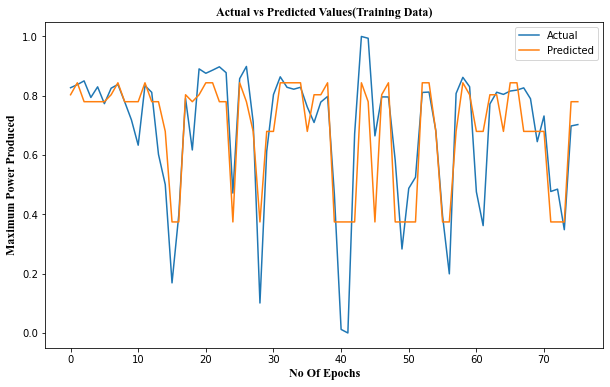

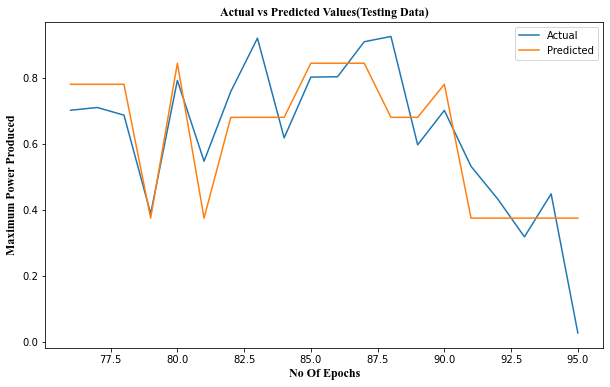

In [55]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[:train_size], y_train, label='Actual')
plt.plot(df.index[:train_size], y_train_pred, label='Predicted')
plt.title("Actual vs Predicted Values(Training Data)", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()

plt.show()


plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size:], y_test, label='Actual')
plt.plot(df.index[train_size:], y_pred, label='Predicted')
plt.title("Actual vs Predicted Values(Testing Data)" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend(loc = 'upper right')

plt.show()

In [56]:
results = results.append({"Model_name":"Decision Tree Regressor","RMSE": rmse_1}, ignore_index = True)
results

,Model_name,RMSE
0,Radial Basis Function Neural Network,25.202064
1,LSTM Neural Network,52.293499
2,Modular Neural Network,23.481034
3,Linear Regression(G and T),25.717654
4,Support Vector Machines,27.508677
5,Decision Tree Regressor,27.727061


# Random forest regressor

In [57]:



X = df[['Temperature(Â°C)', 'Irradiance(W/m2)']].values
y = df["Power(Watts)"].values

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

train_size = int(len(df) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

n_estimators = 200  # number of decision trees
model = RandomForestRegressor(n_estimators=n_estimators, max_depth= 50, min_samples_leaf=7)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

y_pred = model.predict(X_test)
y_pred_orig = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

y_train_pred = model.predict(X_train)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred.reshape(-1, 1))

rmse_1 = np.sqrt(mean_squared_error(y[train_size:], y_pred_orig))

rmse_train = np.sqrt(mean_squared_error(y[:train_size], y_train_pred_orig))

print(f'Test Root Mean Squared Error: {rmse_1:.10f}')
print(f'Train Root Mean Squared Error: {rmse_train:.10f}')

Test Root Mean Squared Error: 26.7485104166
Train Root Mean Squared Error: 23.4767077053


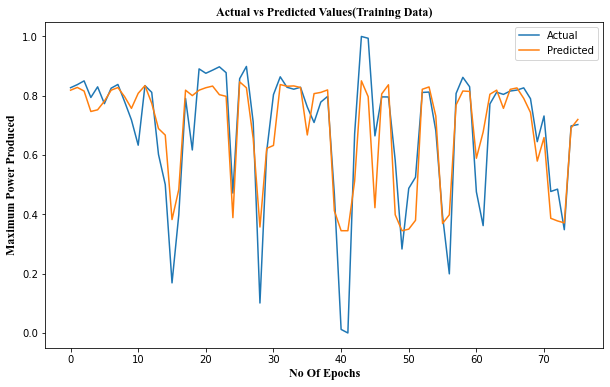

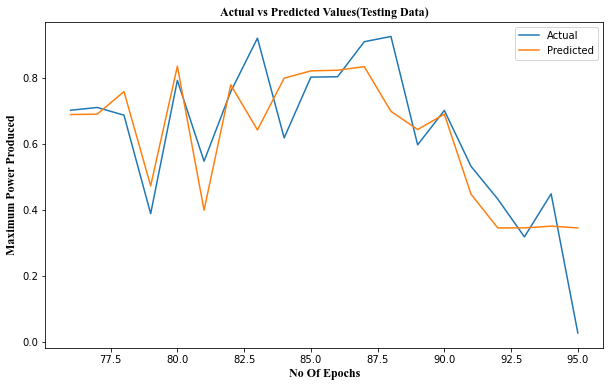

In [58]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[:train_size], y_train, label='Actual')
plt.plot(df.index[:train_size], y_train_pred, label='Predicted')
plt.title("Actual vs Predicted Values(Training Data)", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()

plt.show()


plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size:], y_test, label='Actual')
plt.plot(df.index[train_size:], y_pred, label='Predicted')
plt.title("Actual vs Predicted Values(Testing Data)" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend(loc = 'upper right')

plt.show()

In [59]:
results = results.append({"Model_name":"Random forest Regressor","RMSE": rmse_1}, ignore_index = True)
results

,Model_name,RMSE
0,Radial Basis Function Neural Network,25.202064
1,LSTM Neural Network,52.293499
2,Modular Neural Network,23.481034
3,Linear Regression(G and T),25.717654
4,Support Vector Machines,27.508677
5,Decision Tree Regressor,27.727061
6,Random forest Regressor,26.748510


# Orthogonal linear regression

In [60]:
X = df.copy()[['Temperature(Â°C)', "Irradiance(W/m2)"]].values
y = df.copy()['Power(Watts)'].values

scaler_X =  MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

train_size = int(len(df) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

model = OrthogonalMatchingPursuit()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

In [61]:
y_pred = model.predict(X_test)
y_pred_orig = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

y_train_pred = model.predict(X_train)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred.reshape(-1, 1))

rmse_1 = np.sqrt(mean_squared_error(y[train_size:], y_pred_orig))

rmse_train = np.sqrt(mean_squared_error(y[:train_size], y_train_pred_orig))

print(f'Test Root Mean Squared Error: {rmse_1:.10f}')

results = results.append({"Model_name":"Orthogonal linear regression","RMSE": rmse_1}, ignore_index = True)
results

Test Root Mean Squared Error: 26.0086042152


,Model_name,RMSE
0,Radial Basis Function Neural Network,25.202064
1,LSTM Neural Network,52.293499
2,Modular Neural Network,23.481034
3,Linear Regression(G and T),25.717654
4,Support Vector Machines,27.508677
5,Decision Tree Regressor,27.727061
6,Random forest Regressor,26.748510
7,Orthogonal linear regression,26.008604


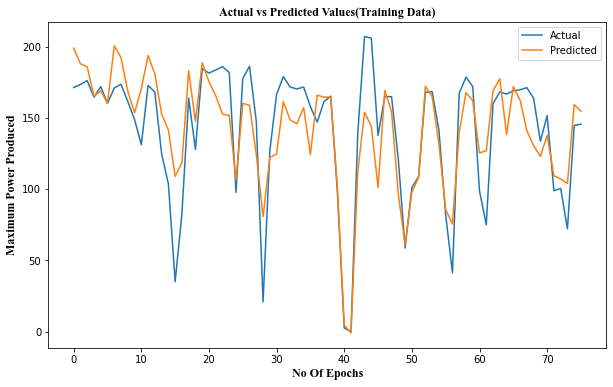

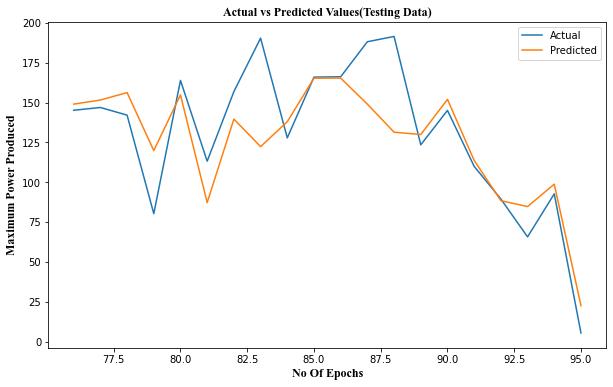

In [62]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[:train_size], y[:train_size], label='Actual')
plt.plot(df.index[:train_size], y_train_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Training Data)", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()

plt.show()


plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size:], y[train_size:], label='Actual')
plt.plot(df.index[train_size:], y_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Testing Data)" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend(loc = 'upper right')

plt.show()

# Quantile Linear regression

In [63]:
import numpy as np
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

X = df.copy()[['Temperature(Â°C)', "Irradiance(W/m2)"]].values
y = df.copy()['Power(Watts)'].values

scaler_X =  MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

train_size = int(len(df) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]


quantile_model = sm.QuantReg(y_train, X_train)
quantile_result = quantile_model.fit(q=0.2)  # Change the quantile value as needed

predicted_power = quantile_result.predict(X)



In [64]:
y_pred = quantile_result.predict(X_test)
y_pred_orig = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

y_train_pred = quantile_result.predict(X_train)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred.reshape(-1, 1))

rmse_1 = np.sqrt(mean_squared_error(y[train_size:], y_pred_orig))

rmse_train = np.sqrt(mean_squared_error(y[:train_size], y_train_pred_orig))

print(f'Test Root Mean Squared Error: {rmse_1:.10f}')
print(f'Train Root Mean Squared Error: {rmse_train:.10f}')

results = results.append({"Model_name":"Quantile linear regression","RMSE": rmse_1}, ignore_index = True)
results

Test Root Mean Squared Error: 31.4701943569
Train Root Mean Squared Error: 28.9473883330


,Model_name,RMSE
0,Radial Basis Function Neural Network,25.202064
1,LSTM Neural Network,52.293499
2,Modular Neural Network,23.481034
3,Linear Regression(G and T),25.717654
4,Support Vector Machines,27.508677
5,Decision Tree Regressor,27.727061
6,Random forest Regressor,26.748510
7,Orthogonal linear regression,26.008604
8,Quantile linear regression,31.470194


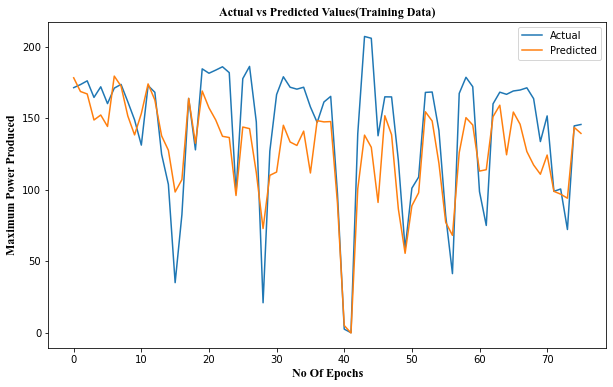

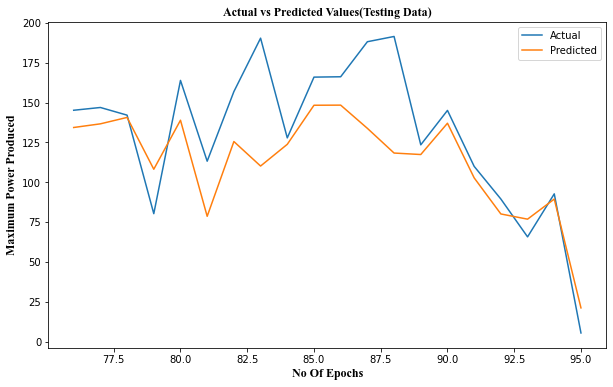

In [65]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[:train_size], y[:train_size], label='Actual')
plt.plot(df.index[:train_size], y_train_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Training Data)", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()

plt.show()


plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size:], y[train_size:], label='Actual')
plt.plot(df.index[train_size:], y_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Testing Data)" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend(loc = 'upper right')

plt.show()

# Linear Regression(G^2 and T)

In [66]:
X = df[['Temperature(Â°C)', 'Irradiance(W/m2)']]
X["Irradiance(W/m2)"] = X["Irradiance(W/m2)"]**2
X = X.values
y = df["Power(Watts)"].values

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

train_size = int(len(df) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]



reg_model = LinearRegression()

reg_model.fit(X_train, y_train)

y_pred = reg_model.predict(X_test)
mse_4 = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse_4:.10f}')
b0 = reg_model.intercept_[0]
b = reg_model.coef_

print("Regression equation: Y = P = {:.2f}T + {:.2f}IR^2 - {:.2f}".format(b[0][0], b[0][1], abs(b0)))

Mean Squared Error: 0.0179003133
Regression equation: Y = P = 0.07T + 0.80IR^2 - 0.16


In [67]:
y_pred = reg_model.predict(X_test)
y_pred_orig = scaler_y.inverse_transform(y_pred)

y_train_pred = reg_model.predict(X_train)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred)

rmse_1 = np.sqrt(mean_squared_error(y[train_size:], y_pred_orig))

rmse_train = np.sqrt(mean_squared_error(y[:train_size], y_train_pred_orig))

print(f'Test Root Mean Squared Error: {rmse_1:.10f}')
print(f'Train Root Mean Squared Error: {rmse_train:.10f}')

results = results.append({"Model_name":"Linear regression(G^2 and T)","RMSE": rmse_1}, ignore_index = True)
results

Test Root Mean Squared Error: 27.7044311526
Train Root Mean Squared Error: 26.5799859945


,Model_name,RMSE
0,Radial Basis Function Neural Network,25.202064
1,LSTM Neural Network,52.293499
2,Modular Neural Network,23.481034
3,Linear Regression(G and T),25.717654
4,Support Vector Machines,27.508677
5,Decision Tree Regressor,27.727061
6,Random forest Regressor,26.748510
7,Orthogonal linear regression,26.008604
8,Quantile linear regression,31.470194
9,Linear regression(G^2 and T),27.704431


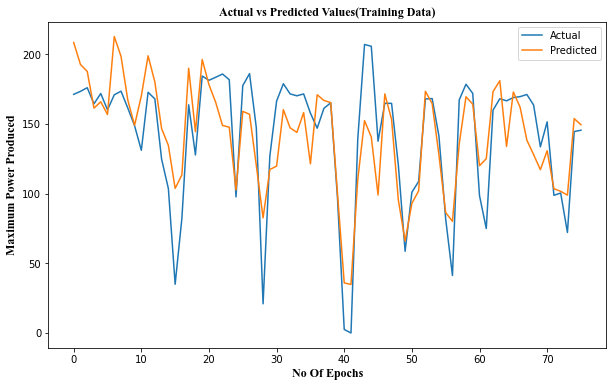

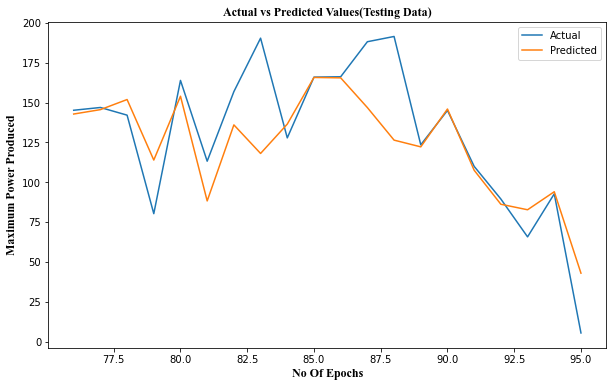

In [68]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[:train_size], y[:train_size], label='Actual')
plt.plot(df.index[:train_size], y_train_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Training Data)", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()

plt.show()


plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size:], y[train_size:], label='Actual')
plt.plot(df.index[train_size:], y_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Testing Data)" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend(loc = 'upper right')

plt.show()

# Linear Regression(G^2 and T^2)

In [69]:
X = df[['Temperature(Â°C)', 'Irradiance(W/m2)']]
X["Temperature(Â°C)"] = X["Temperature(Â°C)"]**2
X["Irradiance(W/m2)"] = X["Irradiance(W/m2)"]**2
X = X.values
y = df["Power(Watts)"].values

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

train_size = int(len(df) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]



reg_model = LinearRegression()

reg_model.fit(X_train, y_train)

y_pred = reg_model.predict(X_test)
mse_4 = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse_4:.10f}')
b0 = reg_model.intercept_[0]
b = reg_model.coef_

print("Regression equation: Y = P = {:.2f}T + {:.2f}IR^2 - {:.2f}".format(b[0][0], b[0][1], abs(b0)))

Mean Squared Error: 0.0184101891
Regression equation: Y = P = -0.02T + 0.87IR^2 - 0.16


In [70]:
y_pred = reg_model.predict(X_test)
y_pred_orig = scaler_y.inverse_transform(y_pred)

y_train_pred = reg_model.predict(X_train)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred)

rmse_1 = np.sqrt(mean_squared_error(y[train_size:], y_pred_orig))

rmse_train = np.sqrt(mean_squared_error(y[:train_size], y_train_pred_orig))

print(f'Test Root Mean Squared Error: {rmse_1:.10f}')
print(f'Train Root Mean Squared Error: {rmse_train:.10f}')

results = results.append({"Model_name":"Linear regression(G^2 and T^2)","RMSE": rmse_1}, ignore_index = True)
results

Test Root Mean Squared Error: 28.0962297707
Train Root Mean Squared Error: 26.6458616970


,Model_name,RMSE
0,Radial Basis Function Neural Network,25.202064
1,LSTM Neural Network,52.293499
2,Modular Neural Network,23.481034
3,Linear Regression(G and T),25.717654
4,Support Vector Machines,27.508677
5,Decision Tree Regressor,27.727061
6,Random forest Regressor,26.748510
7,Orthogonal linear regression,26.008604
8,Quantile linear regression,31.470194
9,Linear regression(G^2 and T),27.704431


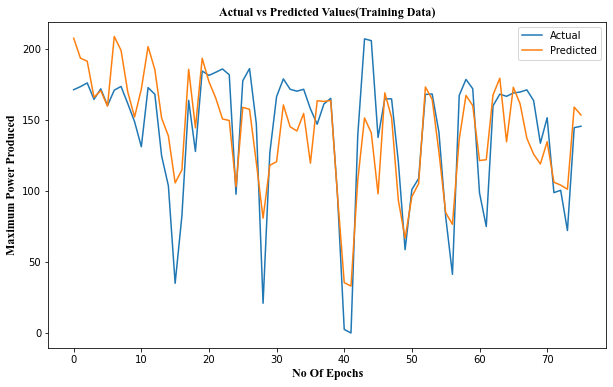

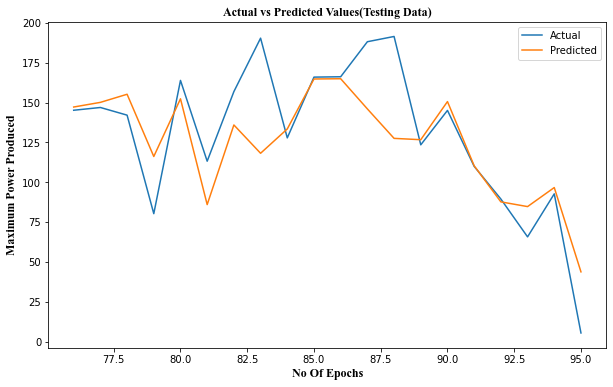

In [71]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[:train_size], y[:train_size], label='Actual')
plt.plot(df.index[:train_size], y_train_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Training Data)", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()

plt.show()


plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size:], y[train_size:], label='Actual')
plt.plot(df.index[train_size:], y_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Testing Data)" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend(loc = 'upper right')

plt.show()

# Linear Regression(G and T^2)

In [72]:
X = df[['Temperature(Â°C)', 'Irradiance(W/m2)']]
X["Temperature(Â°C)"] = X["Temperature(Â°C)"]**2
X = X.values
y = df["Power(Watts)"].values

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

train_size = int(len(df) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]



reg_model = LinearRegression()

reg_model.fit(X_train, y_train)

y_pred = reg_model.predict(X_test)
mse_4 = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse_4:.10f}')
b0 = reg_model.intercept_[0]
b = reg_model.coef_

print("Regression equation: Y = P = {:.2f}T + {:.2f}IR^2 - {:.2f}".format(b[0][0], b[0][1], abs(b0)))

Mean Squared Error: 0.0157871511
Regression equation: Y = P = -0.00T + 0.98IR^2 - 0.01


In [73]:
y_pred = reg_model.predict(X_test)
y_pred_orig = scaler_y.inverse_transform(y_pred)

y_train_pred = reg_model.predict(X_train)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred)

rmse_1 = np.sqrt(mean_squared_error(y[train_size:], y_pred_orig))

rmse_train = np.sqrt(mean_squared_error(y[:train_size], y_train_pred_orig))

print(f'Test Root Mean Squared Error: {rmse_1:.10f}')
print(f'Train Root Mean Squared Error: {rmse_train:.10f}')

results = results.append({"Model_name":"Linear regression(G and T^2)", "RMSE": rmse_1}, ignore_index = True)
results

Test Root Mean Squared Error: 26.0178139927
Train Root Mean Squared Error: 24.7998077615


,Model_name,RMSE
0,Radial Basis Function Neural Network,25.202064
1,LSTM Neural Network,52.293499
2,Modular Neural Network,23.481034
3,Linear Regression(G and T),25.717654
4,Support Vector Machines,27.508677
5,Decision Tree Regressor,27.727061
6,Random forest Regressor,26.748510
7,Orthogonal linear regression,26.008604
8,Quantile linear regression,31.470194
9,Linear regression(G^2 and T),27.704431


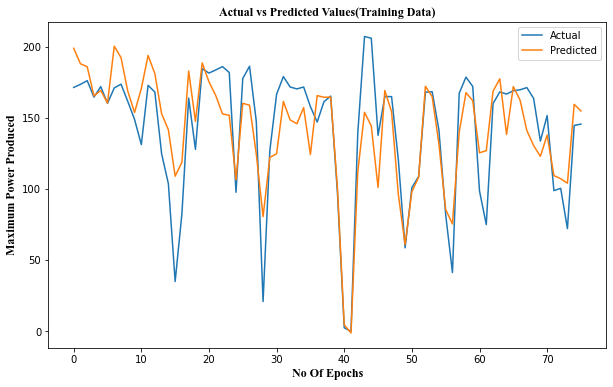

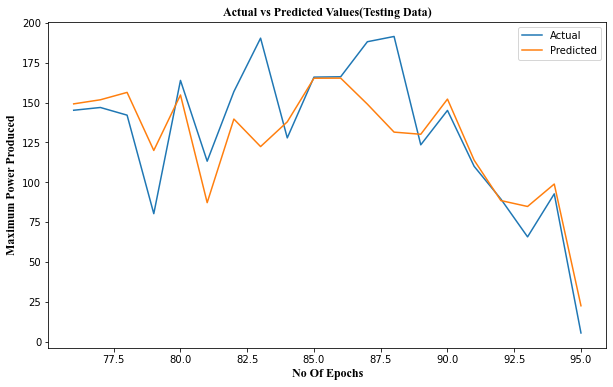

In [74]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[:train_size], y[:train_size], label='Actual')
plt.plot(df.index[:train_size], y_train_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Training Data)", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()

plt.show()


plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size:], y[train_size:], label='Actual')
plt.plot(df.index[train_size:], y_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Testing Data)" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend(loc = 'upper right')

plt.show()

# Ridge Regression

In [75]:

X = df[[ 'Irradiance(W/m2)', 'Temperature(Â°C)']].values
y = df["Power(Watts)"].values

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

train_size = int(len(df) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]



reg_model = Ridge(alpha=0.3)

reg_model.fit(X_train, y_train)

y_pred = reg_model.predict(X_test)
mse_4 = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse_4:.10f}')
b0 = reg_model.intercept_[0]
b = reg_model.coef_

y_pred = reg_model.predict(X_test)
y_pred_orig = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

y_train_pred = reg_model.predict(X_train)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred.reshape(-1, 1))

rmse_1 = np.sqrt(mean_squared_error(y[train_size:], y_pred_orig))

rmse_train = np.sqrt(mean_squared_error(y[:train_size], y_train_pred_orig))

print(f'Test Root Mean Squared Error: {rmse_1:.10f}')
print(f'Train Root Mean Squared Error: {rmse_train:.10f}')

results = results.append({"Model_name":"Ridge regression","RMSE": rmse_1}, ignore_index = True)
results

Mean Squared Error: 0.0155001827
Test Root Mean Squared Error: 25.7802622153
Train Root Mean Squared Error: 25.1128484512


,Model_name,RMSE
0,Radial Basis Function Neural Network,25.202064
1,LSTM Neural Network,52.293499
2,Modular Neural Network,23.481034
3,Linear Regression(G and T),25.717654
4,Support Vector Machines,27.508677
5,Decision Tree Regressor,27.727061
6,Random forest Regressor,26.748510
7,Orthogonal linear regression,26.008604
8,Quantile linear regression,31.470194
9,Linear regression(G^2 and T),27.704431


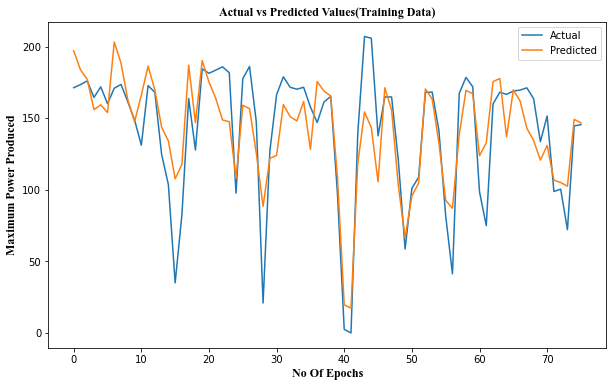

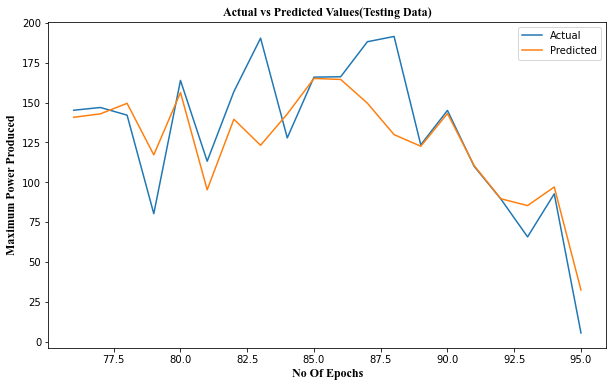

In [76]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[:train_size], y[:train_size], label='Actual')
plt.plot(df.index[:train_size], y_train_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Training Data)", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()

plt.show()


plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size:], y[train_size:], label='Actual')
plt.plot(df.index[train_size:], y_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Testing Data)" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend(loc = 'upper right')

plt.show()

# Kernel Ridge Regression

In [77]:
from sklearn.kernel_ridge import KernelRidge

X = df[[ 'Irradiance(W/m2)', 'Temperature(Â°C)']].values
y = df["Power(Watts)"].values

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

train_size = int(len(df) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]



reg_model = KernelRidge(kernel='rbf', alpha=0.1)

reg_model.fit(X_train, y_train)

y_pred = reg_model.predict(X_test)
mse_4 = mean_squared_error(y_test, y_pred)


y_pred = reg_model.predict(X_test)
y_pred_orig = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

y_train_pred = reg_model.predict(X_train)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred.reshape(-1, 1))

rmse_1 = np.sqrt(mean_squared_error(y[train_size:], y_pred_orig))

rmse_train = np.sqrt(mean_squared_error(y[:train_size], y_train_pred_orig))

print(f'Test Root Mean Squared Error: {rmse_1:.10f}')
print(f'Train Root Mean Squared Error: {rmse_train:.10f}')

results = results.append({"Model_name":"Kernal Ridge regression","RMSE": rmse_1}, ignore_index = True)
results

Test Root Mean Squared Error: 23.2215934773
Train Root Mean Squared Error: 22.2295339814


,Model_name,RMSE
0,Radial Basis Function Neural Network,25.202064
1,LSTM Neural Network,52.293499
2,Modular Neural Network,23.481034
3,Linear Regression(G and T),25.717654
4,Support Vector Machines,27.508677
5,Decision Tree Regressor,27.727061
6,Random forest Regressor,26.748510
7,Orthogonal linear regression,26.008604
8,Quantile linear regression,31.470194
9,Linear regression(G^2 and T),27.704431


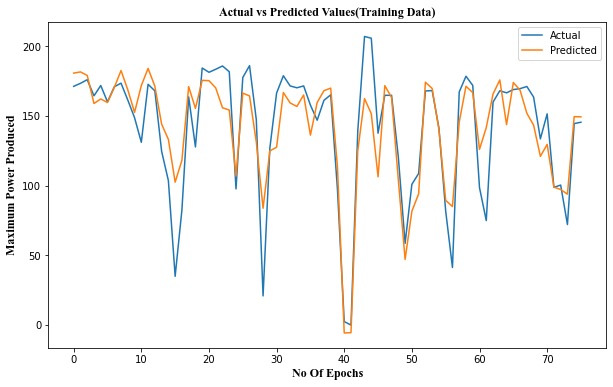

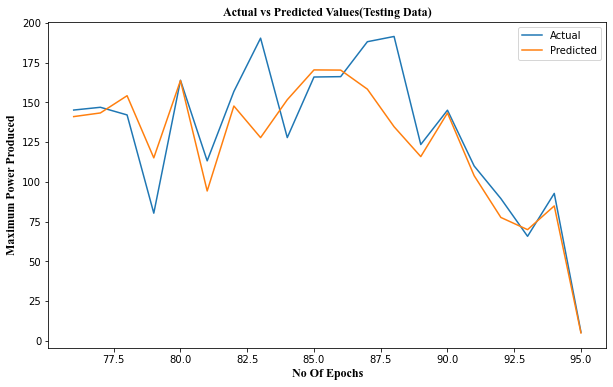

In [78]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[:train_size], y[:train_size], label='Actual')
plt.plot(df.index[:train_size], y_train_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Training Data)", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()

plt.show()


plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size:], y[train_size:], label='Actual')
plt.plot(df.index[train_size:], y_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Testing Data)" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend(loc = 'upper right')

plt.show()

In [79]:
results.sort_values("RMSE").reset_index().drop("index", axis = 1)

,Model_name,RMSE
0,Kernal Ridge regression,23.221593
1,Modular Neural Network,23.481034
2,Radial Basis Function Neural Network,25.202064
3,Linear Regression(G and T),25.717654
4,Ridge regression,25.780262
5,Orthogonal linear regression,26.008604
6,Linear regression(G and T^2),26.017814
7,Random forest Regressor,26.748510
8,Support Vector Machines,27.508677
9,Linear regression(G^2 and T),27.704431


In [80]:
results.sort_values("RMSE").reset_index().drop("index", axis = 1)

,Model_name,RMSE
0,Kernal Ridge regression,23.221593
1,Modular Neural Network,23.481034
2,Radial Basis Function Neural Network,25.202064
3,Linear Regression(G and T),25.717654
4,Ridge regression,25.780262
5,Orthogonal linear regression,26.008604
6,Linear regression(G and T^2),26.017814
7,Random forest Regressor,26.748510
8,Support Vector Machines,27.508677
9,Linear regression(G^2 and T),27.704431
